In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Prepare the Data

In [9]:
def strip_dollar(s):
    '''
    convert price string with dollar notation to float like '$1,250'
    '''
    if s == '':
        return np.NaN
    return np.float(s.replace('$', '').replace(',', ''))

In [98]:
# Calendar
seattle_cal = pd.read_csv('./data/seattle/calendar.csv', 
                          index_col='date', parse_dates=['date'], converters={'price':strip_dollar})
boston_cal = pd.read_csv('./data/boston/calendar.csv', 
                          index_col='date', parse_dates=['date'], converters={'price':strip_dollar})
# Listings
seattle_list = pd.read_csv('./data/seattle/listings.csv', converters={'price':strip_dollar})
boston_list = pd.read_csv('./data/boston/listings.csv', converters={'price':strip_dollar})

# choose columns
seattle_list = seattle_list[['id', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price']]
boston_list = boston_list[['id', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price']]

In [99]:
# Calendar price
boston_cal_price = boston_cal[boston_cal['available'] == 't'][['listing_id', 'price']]
seattle_cal_price = seattle_cal[seattle_cal['available'] == 't'][['listing_id', 'price']]

# Boston Price Calendar
Let's take a look at the day-to-day changes in the mean price of Boston

In [100]:
boston_price_d = boston_cal_price['price'].resample('D')

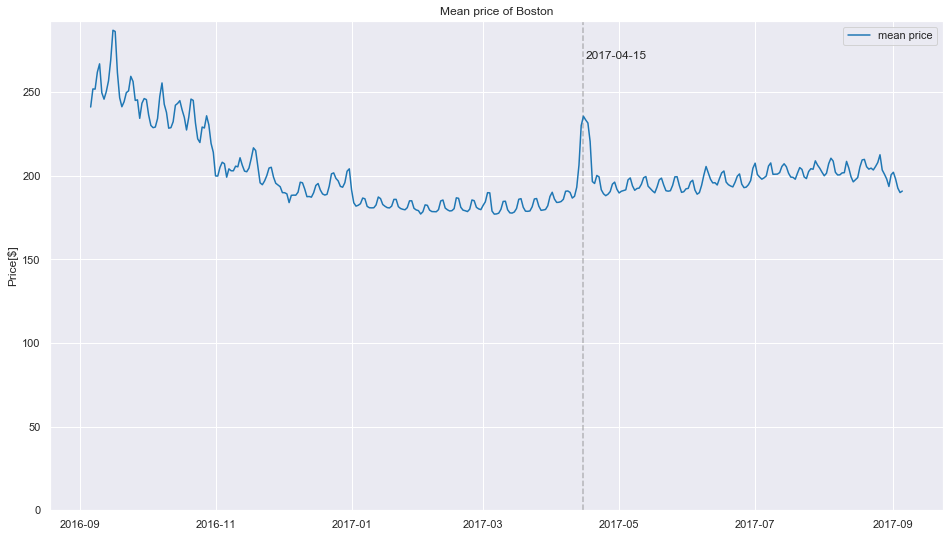

In [101]:
plt.figure(figsize=(16, 9))
plt.title('Mean price of Boston')
plt.plot(boston_price_d.mean(), label='mean price', color='tab:blue')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.ylabel('Price[$]')
plt.vlines('2017-04-15', 0, ymax, linestyle='--', color='tab:gray', alpha=0.5)
plt.gca().annotate('2017-04-15', xy=('2017-04-16', 270))
plt.legend()
plt.show()

## Observation of Boston price
* Prices are dropping rapidly over 2017-01.
* After that, there is a slow upward trend.
* But, there are price peak around 2017-04-15~2017-04-17.
* And, periodic small peaks are observed.

# Question 0: What is small periodic small peaks and one big peak

## About periodic peaks
It's a weekly period of Fridy and Saturaday<br>
It seems natural that weekend room rates would go up.

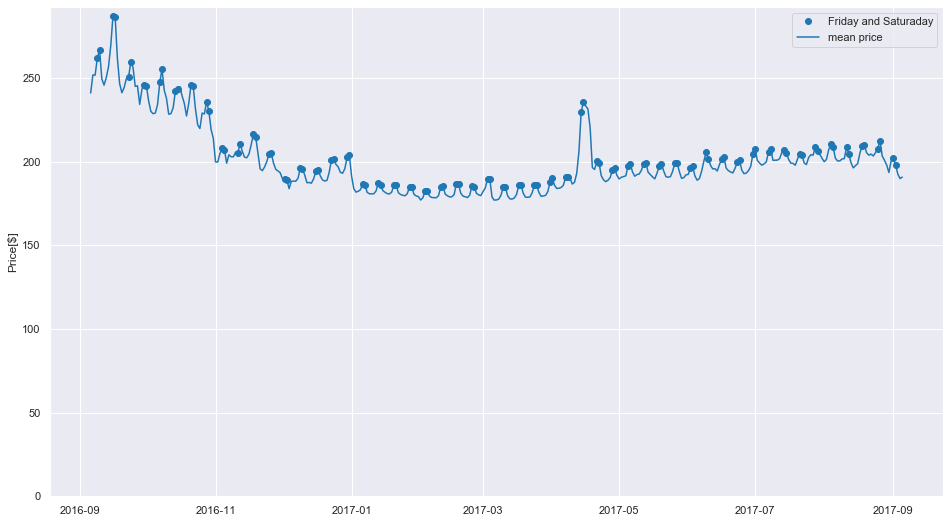

In [102]:
plt.figure(figsize=(16, 9))
boston_mean = boston_price_d.mean()
plt.plot(boston_mean[boston_mean.index.weekday.isin([4, 5])], 
         marker='o', linewidth=0, color='tab:blue', label='Friday and Saturaday')
plt.plot(boston_mean, color='tab:blue', label='mean price')
plt.legend()
plt.ylim(0, ymax)
plt.ylabel('Price[$]')
plt.show()

## What is the big peak at 2017-04
I googled to see if there were any major events in Boston in April 2017.<br>
Then I found Boston Marathon was held at April 17.<br>
May be it's a cause of price peak of 2017-04-14 to 2017-04-16.

# Question 1: What rooms raised their prices during the event?

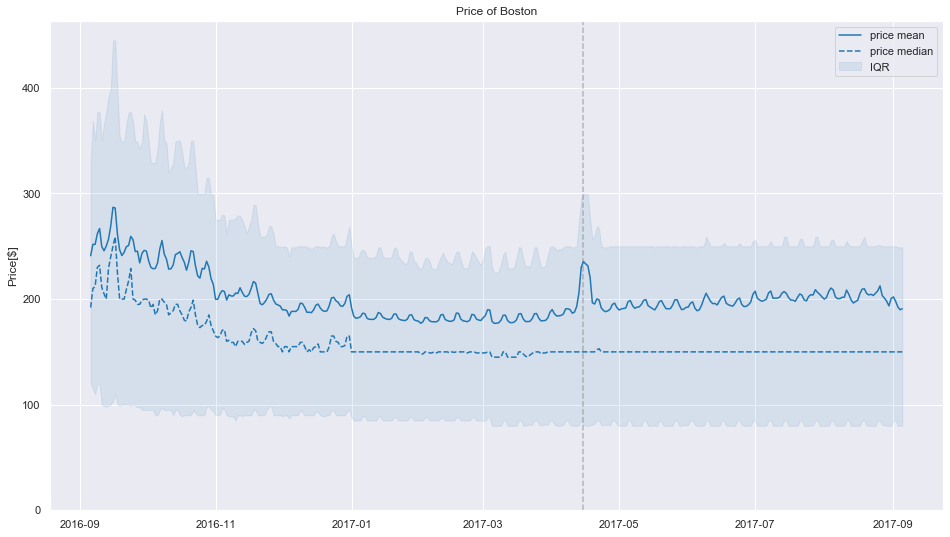

In [103]:
plt.figure(figsize=(16, 9))
plt.title('Price of Boston')
plt.plot(boston_price_d.mean(), label='price mean', color='tab:blue')
plt.plot(boston_price_d.median(), label='price median', color='tab:blue', linestyle='--')
plt.fill_between(boston_price_d.mean().index, 
                 boston_price_d.quantile(0.75).values.flatten(), 
                 boston_price_d.quantile(0.25).values.flatten(),
                 alpha=0.1, label='IQR', color='tab:blue')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.ylabel('Price[$]')
plt.vlines('2017-04-15', 0, ymax, linestyle='--', color='tab:gray', alpha=0.5)
plt.legend()
plt.show()

## Observation of price range
Median and 25 percentile are flatten but mean and 75 percentile have peak.<br>
So, the price of rooms in the higher price range may be rising?

## Divide the room into higher and lower price
Over 75 percentile rooms are 'higher' and others are 'lower'.

In [104]:
# threshold of top 25% price
price_threshold = boston_cal_price['2017-04-15']['price'].quantile(0.75)

In [105]:
# choose ID
upper_price_id = boston_cal_price['2017-04-15'][boston_cal_price['2017-04-15']['price'] >= price_threshold]['listing_id']
lower_price_id = boston_cal_price['2017-04-15'][boston_cal_price['2017-04-15']['price'] < price_threshold]['listing_id']

In [106]:
# listings
boston_list_higher = boston_list[boston_list['id'].isin(upper_price_id)].reset_index(drop=True)
boston_list_lower = boston_list[boston_list['id'].isin(lower_price_id)].reset_index(drop=True)

### Look up "Property Type"

In [107]:
# Property type(Upper)
boston_list_higher['property_type'].value_counts()

Apartment          305
House               43
Condominium         26
Loft                 4
Other                3
Boat                 3
Townhouse            2
Bed & Breakfast      1
Name: property_type, dtype: int64

In [108]:
# Property type(Lower)
boston_list_lower['property_type'].value_counts()

Apartment          752
House              282
Condominium         52
Bed & Breakfast     24
Townhouse           16
Other               10
Loft                10
Boat                 8
Entire Floor         2
Camper/RV            1
Villa                1
Name: property_type, dtype: int64

There is no significant difference in property type.<br>
Top 3 are both 'Apartment', 'House' and 'Condominium'.

### Look up the size of room
Columns of accommodates, bathrooms, bedrooms and beds, I think these are supposed to indicate the size of the room.

In [109]:
print('accomodates mean (higher): ', boston_list_higher['accommodates'].mean())
print('accomodates mean (lower): ', boston_list_lower['accommodates'].mean())

accomodates mean (higher):  4.568475452196383
accomodates mean (lower):  2.418825561312608


In [110]:
print('bathrooms mean (higher): ', boston_list_higher['bathrooms'].mean())
print('bathrooms mean (lower): ', boston_list_lower['bathrooms'].mean())

bathrooms mean (higher):  1.4049479166666667
bathrooms mean (lower):  1.1721739130434783


In [111]:
print('bedrooms mean (higher): ', boston_list_higher['bedrooms'].mean())
print('bedrooms mean (lower): ', boston_list_lower['bedrooms'].mean())

bedrooms mean (higher):  1.812664907651715
bedrooms mean (lower):  1.0432152117545377


In [112]:
print('beds mean (higher): ', boston_list_higher['beds'].mean())
print('beds mean (lower): ', boston_list_lower['beds'].mean())

beds mean (higher):  2.2661498708010335
beds mean (lower):  1.3697916666666667


In [113]:
print('beds mean (higher): ', boston_list_higher['price'].mean())
print('beds mean (lower): ', boston_list_lower['price'].mean())

beds mean (higher):  310.99483204134367
beds mean (lower):  122.26943005181347


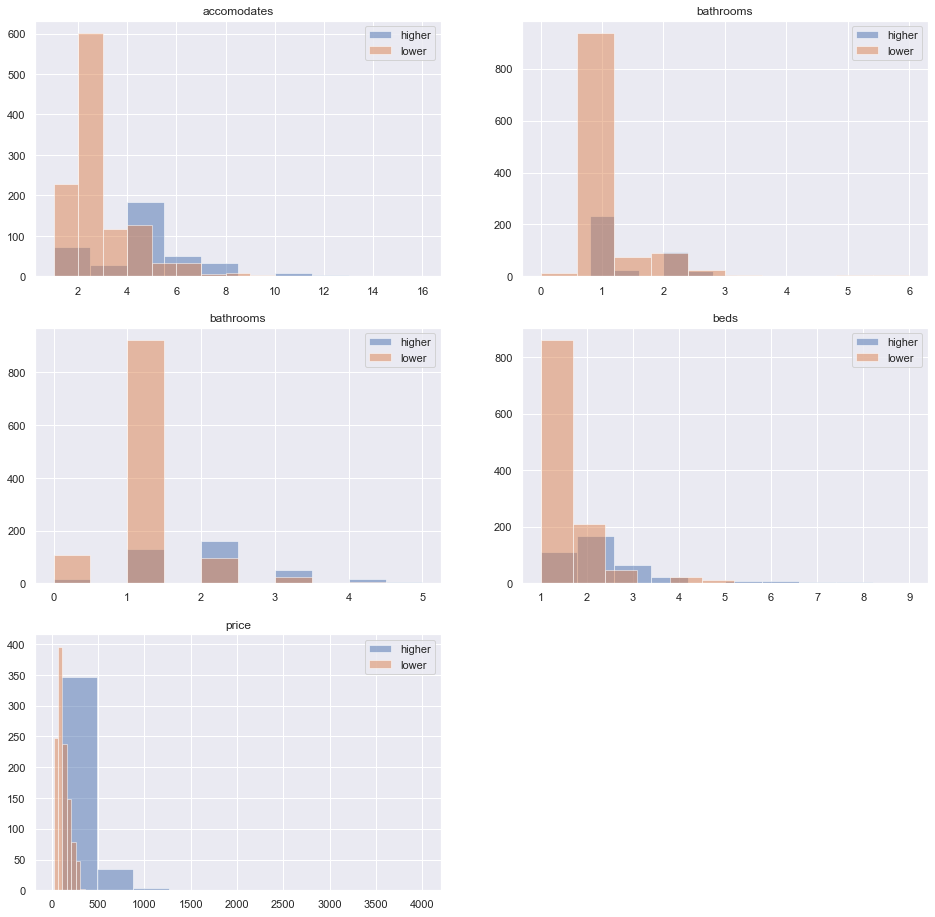

In [115]:
plt.figure(figsize=(16, 16))
ax1 = plt.subplot(321)
ax1.set_title('accomodates')
ax1.hist(boston_list_higher['accommodates'], alpha=0.5, label='higher')
ax1.hist(boston_list_lower['accommodates'], alpha=0.5, label='lower')
ax1.legend()

ax2 = plt.subplot(322)
ax2.set_title('bathrooms')
ax2.hist(boston_list_higher['bathrooms'], alpha=0.5, label='higher')
ax2.hist(boston_list_lower['bathrooms'], alpha=0.5, label='lower')
ax2.legend()

ax3 = plt.subplot(323)
ax3.set_title('bathrooms')
ax3.hist(boston_list_higher['bedrooms'], alpha=0.5, label='higher')
ax3.hist(boston_list_lower['bedrooms'], alpha=0.5, label='lower')
ax3.legend()

ax4 = plt.subplot(324)
ax4.set_title('beds')
ax4.hist(boston_list_higher['beds'], alpha=0.5, label='higher')
ax4.hist(boston_list_lower['beds'], alpha=0.5, label='lower')
ax4.legend()

ax5 = plt.subplot(325)
ax5.set_title('price')
ax5.hist(boston_list_higher['price'], alpha=0.5, label='higher')
ax5.hist(boston_list_lower['price'], alpha=0.5, label='lower')
ax5.legend()

plt.show()

## Discussion
The room that raised their prices during the Boston Marathon were the ones with larger room sizes and originally higher prices.

# TODO:元の価格からいくら上がったのかを見るべきでは？

# memo
* Question 0: 価格が跳ね上がっているのは何か？
  * ボストンマラソンが開催されていた
* Question 1: 価格を吊り上げた部屋はどういう部屋か
  * 高価格帯の部屋が値段を上げている？
  * Question 1-2: 吊り上げなかった部屋はどういう部屋か
  * listing priceとの差異はあるのか
* Question 2: 2016-9~2016-11頃の急激な下落は何が要因か
  * どのような部屋が下落させているのか、させていない部屋は何か
  * 新規参入が増えたことが要因か？
* Question 3: 価格の要因となっているものは何か
  * bostonとseattleで傾向は違うのか
  * 特徴量候補
    * property_type
      * Apartment, House or Other
    * room_type
      * 2種類+その他
    * accommodates
    * bethrooms
    * bedrooms
    * beds
    * amenities
      * 数をカウントする？